# Einstein Gauss-Bonnet in 5D #

In the following example, we will study the static solution of the Gauss-Bonnet gravity theory in five dimensions. The action is 
$$S_{GB} = \frac{1}{2\kappa} \int \sqrt{-g} [R - 2\Lambda + \alpha (R^2 - 4 R^{\mu \nu}R_{\mu \nu} + R^{\mu \nu \rho \sigma}R_{\mu \nu \rho \sigma})] $$

And, the field equations in the vaccum are 

$$G_{\mu \nu} + \Lambda g_{\mu \nu} + \alpha H_{\mu \nu} = 0 = \mathcal{E}_{\mu \nu}$$
$$H_{\mu \nu} = 2[2R^{\mu \alpha}R^{\alpha}_{ \nu}  - R_{\mu \nu} + 2R^{\alpha \lambda} R_{\mu \alpha \nu \lambda} - R_{\mu \alpha \lambda \rho} R^{\alpha \lambda \beta}_{\nu} ] -  \frac{1}{2} g_{\mu \nu} \mathcal{L}_{GB}$$

using the following anzats for the metric 

$$ds^2 = -f(r) g(r)^2 dt^2 + \frac{dr^2}{f(r)} +. r^2 d\Omega^2_{D-3},$$ where the dimesion is $D=5$. From the components of $\mathcal{E}_{tt}$ and $\mathcal{E}_{rr}$ we obtain the equation 

$$[-12\alpha + 3r^2 + 12\alpha f(r)]\frac{d}{dr}f(r) + 6rf(r) - 6r + 2\Lambda r^3 =0. $$ The analytical solution for this equation when $\Lambda=0$ is

$$ f_{\pm}(r) =1 + \frac{r^2}{4\alpha}\left(-1 \pm \sqrt{1 + \frac{8\alpha B + 48\alpha^2}{3r^4}}\right),$$ where $B$ is the integration constant related to the mass of the object. We want our universe to be asymptotically flat and to coincide with the Schwarzschild solution. Thus, the condition when $r$ goes to infinity is imposed as $B=−6\alpha−6M$, obtaining the solution as

$$ f(r) = 1 + \frac{r^2}{4\alpha}\left(-1 + \sqrt{1-\frac{16\alpha M}{r^4}}\right).$$

To solve the differential equation using neural networks, I will use the NeurodiffEq package, imposing that the event horizon is located at $r_h =1$. That is, we restrict ourselves to $\alpha<0$ to ensure a solution exists for all $r>0$, while also ensuring that the masses are positive. First, we load the useful packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl

In [2]:
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.solvers import Solver1D
from neurodiffeq.generators import Generator1D
from neurodiffeq.conditions import IVP # the initial condition
from neurodiffeq.monitors import Monitor1D 
from neurodiffeq.networks import FCNN    # fully-connect neural network
import torch.nn as nn
from torch.optim import Adam #Adam optimizer
from itertools import chain

We will use a fully connected neural network with the initial condition $f(r_h)=f(1)=0$. The neural network has a single input, two hidden layers with 128 neurons each, and the solution as the output. In this network, the optimizer used is Adam, the activation function is the Swish function, and the loss function is the mean minimum residual of the differential equation

$$ \mathcal{L}_{loss}(p) = \int_{\Omega} [\mathcal{L} f(x,t) - g(x,t)]^2 dx dt,  $$ where $\mathcal{L}$ is the differential operator and the initial conditions are imposed in the following from 
$$f(x) = f_0 + (1-e^{-(x-x_0)})\text{ANN}(x) $$

Training Progress:   0%|                                     | 0/5000 [00:00<?, ?it/s]

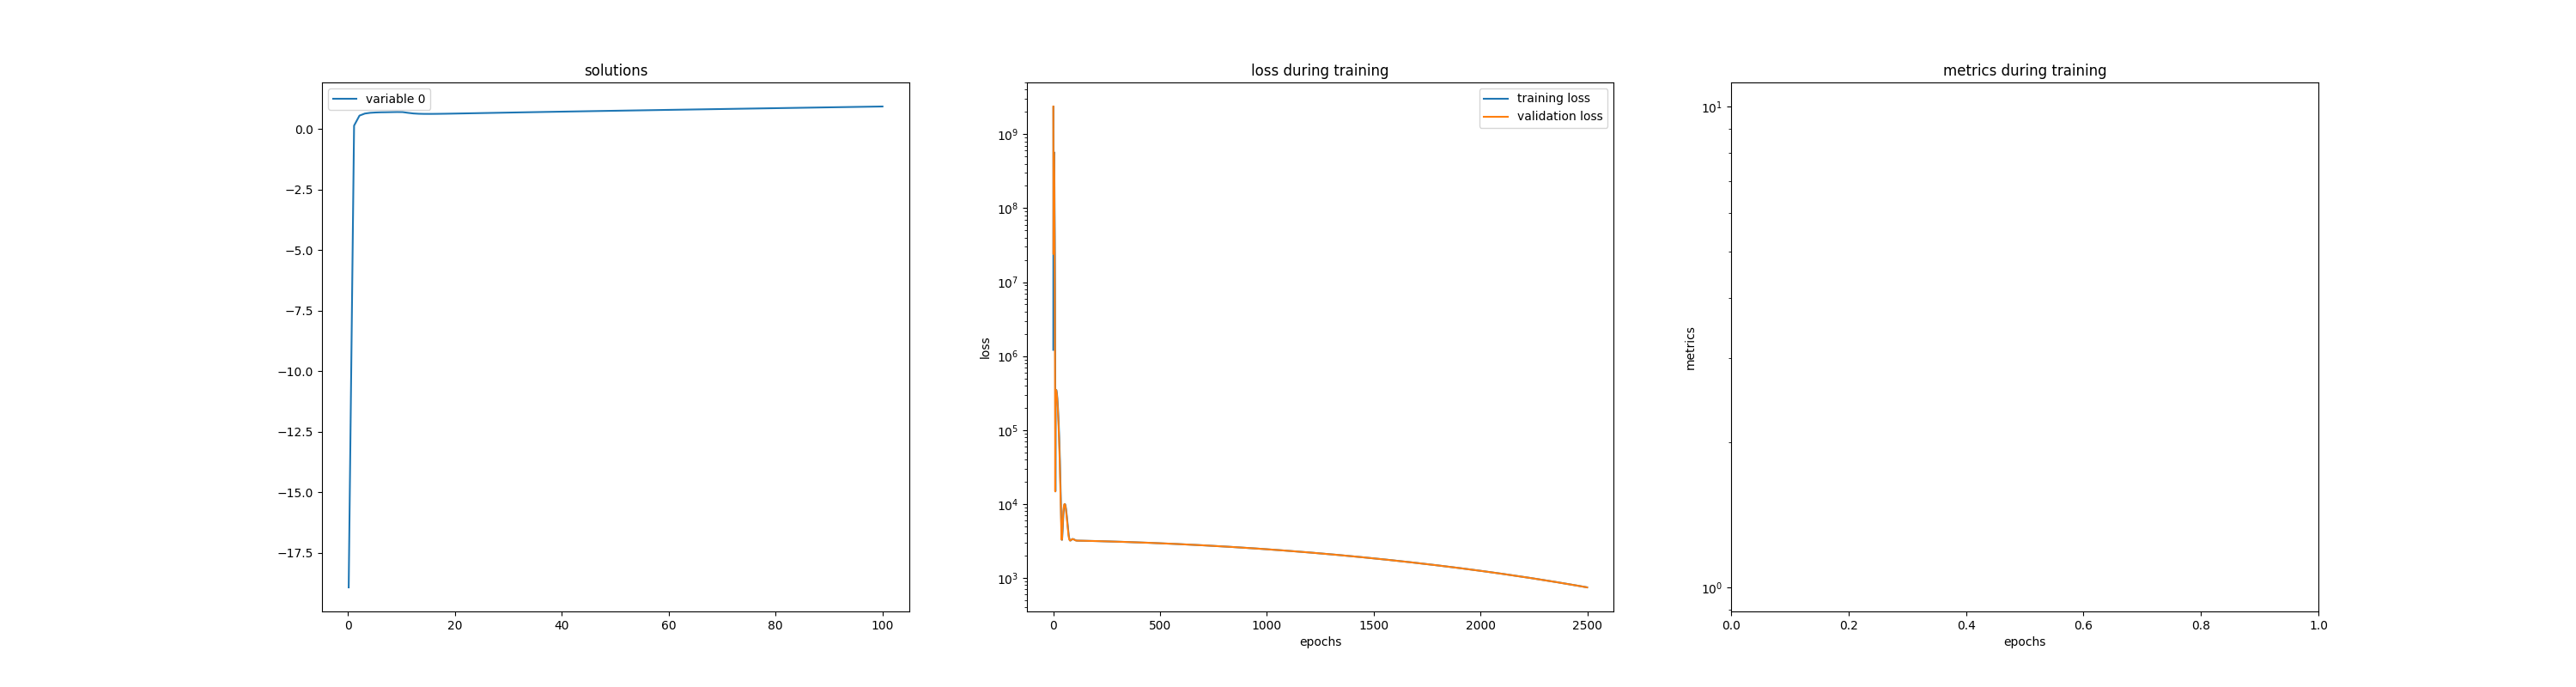

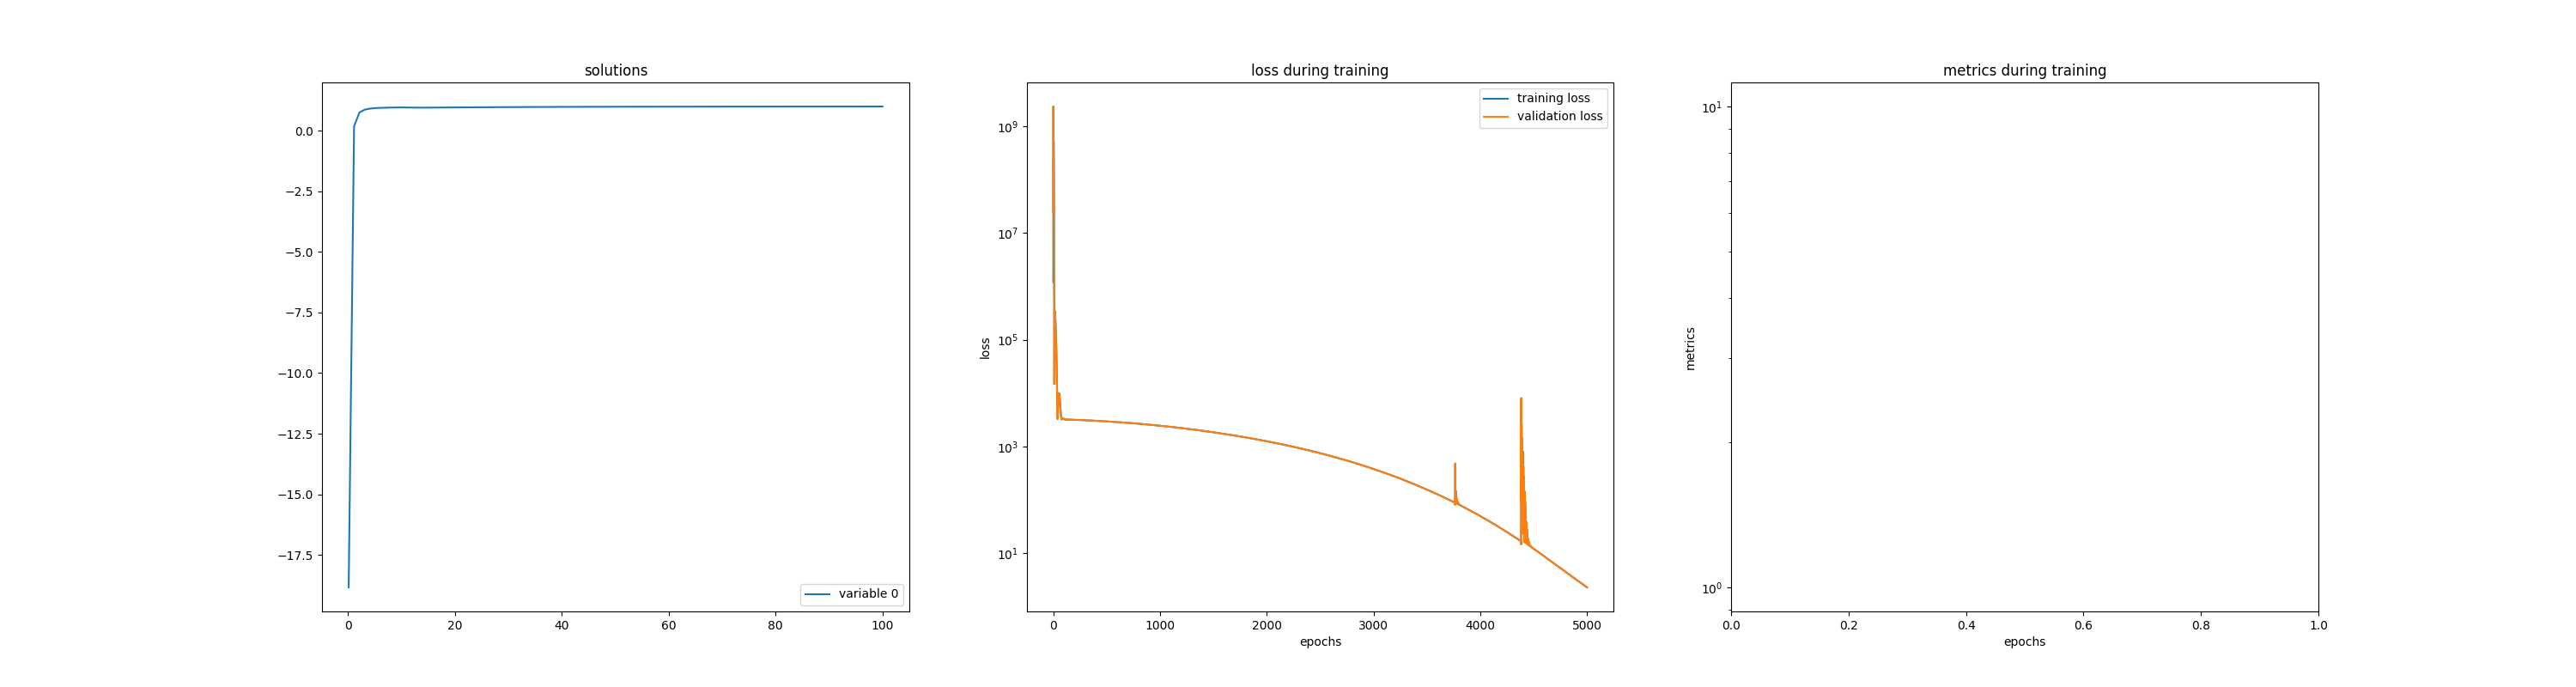

In [3]:
#Let's put the constants
Lambda =0 #Flat =0, De-Sitter > 0 or AntiDe-Sitter < 0 
alpha=-0.001 #The coupling of the Gauss-Bonnet action

# Let's create a monitor first
monitor = Monitor1D(t_min=0.1, t_max=100, check_every=2500)
# and turn it into a Callback instance
monitor_callback = monitor.to_callback()

simple_schw = lambda u, t: [diff(u, t)*(-12*alpha +3*t*t +12*alpha*u) + 6*t*u - 6*t + 2*Lambda*t*t*t]# Schw with the cosmological constant set it to zero and r_s = 1
init_val_h = [IVP(t_0=1.0,u_0=0.0)]#      # specify the initial conditon

## Neural network
g1 = Generator1D(size=512 ,t_min=0.1,t_max=10,method='log-spaced')
g2 = Generator1D(size=512, t_min=10,t_max=100,method='equally-spaced')
train_generator = g1 + g2
v1 = Generator1D(size= 512,t_min=0.1,t_max=10,method='log-spaced')
v2 = Generator1D(size=512, t_min=10,t_max=100,method='equally-spaced')
valid_gen = v1 + v2
nets_lv = [FCNN(n_input_units=1, hidden_units=(128, 128), actv=nn.SiLU)] #SiLU (Swish) condition just to try and play
# solve the ODE
Adam_ho = Adam( chain.from_iterable(n.parameters() for n in nets_lv), # this gives all parameters in `nets`
        lr=0.02, )
solver = Solver1D(
    ode_system=simple_schw, conditions=init_val_h,t_min=0.1,t_max=100, train_generator = train_generator, valid_generator= valid_gen ,nets = nets_lv
, optimizer=Adam_ho)
solver.fit(max_epochs=5000, callbacks=[monitor_callback])

# Get the solution
solution_lv = solver.get_solution()

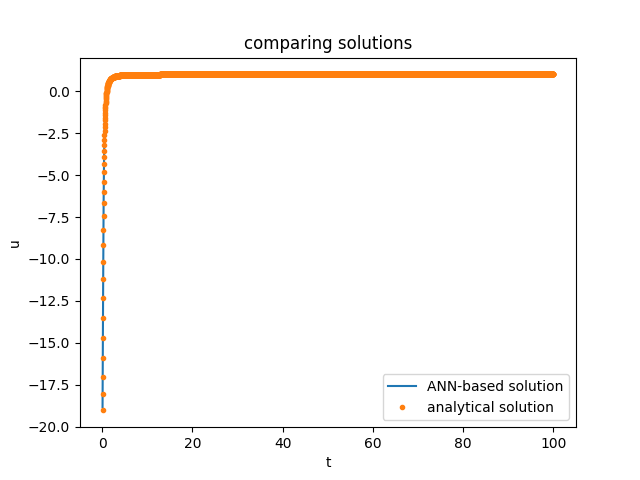

In [4]:
ts = np.linspace(0.1, 100, 5000)
u_net = solution_lv(ts, to_numpy=True)
M = 0.5-alpha
u_ana = 1 + (ts**2/(4*(alpha)))*(-1 + np.sqrt(1 - 16*alpha*M/(ts**4)))

plt.figure()
plt.plot(ts, u_net, label='ANN-based solution')
plt.plot(ts, u_ana, '.', label='analytical solution')
plt.ylabel('u')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()


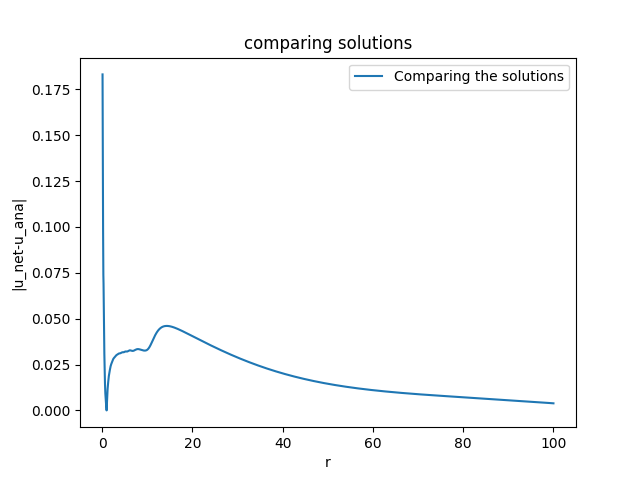

0.019159922687514482


In [5]:
plt.figure()
plt.plot(ts,np.abs(u_net-u_ana), label='Comparing the solutions')
plt.ylabel('|u_net-u_ana|')
plt.xlabel('r')
plt.title('comparing solutions')
plt.legend()
plt.show()
print(np.mean(np.abs(u_net-u_ana)))

**In this case the solution have a precision $\sim 10^{-2}$**

# Compactification of the r coordinate #
If we perform the compactification of the coordinate $ r = \tan(x)$ where $x \in [0,\pi /2)$ to address the globality of the solution (i.e $r \rightarrow \infty \Rightarrow x \rightarrow \pi /2$), the differential equation becomes 

$$ \left(\left(12 \alpha  f \! \left(x \right)-12 \alpha -3\right) \left(\cos^{3}\left(x \right)\right)+3 \cos \! \left(x \right)\right) \left(\frac{d}{d x}f \! \left(x \right)\right)+6 \sin \! \left(x \right) \left(f \! \left(x \right)-1\right)$$

if we solve this equation for $f(x)$, we obtain 
$$ f_\pm(x) =\frac{\pm \sqrt{9+\left(9+144 \alpha^{2}+\left(-24 \textit{B} +72\right) \alpha \right) \left(\cos^{4}\left(x \right)\right)-18 \left(\cos^{2}\left(x \right)\right)}-3+\left(12 \alpha +3\right) \left(\cos^{2}\left(x \right)\right)}{12 \alpha  \cos \! \left(x \right)^{2}},$$

where $B$ is the integration constant related to the mass. To obtain a regual solution $B = 3+6M+6\alpha$. Then the solution is the (+) branch 
$$ f(x) = \frac{\left(4 \alpha +1\right) \left(\cos^{2}\left(x \right)\right)-1+\sqrt{-16 \left(\cos^{4}\left(x \right)\right) \alpha  M +\cos^{4}\left(x \right)-2 \left(\cos^{2}\left(x \right)\right)+1}}{4 \alpha  \cos \! \left(x \right)^{2}}$$. Solving the equation with a NN 

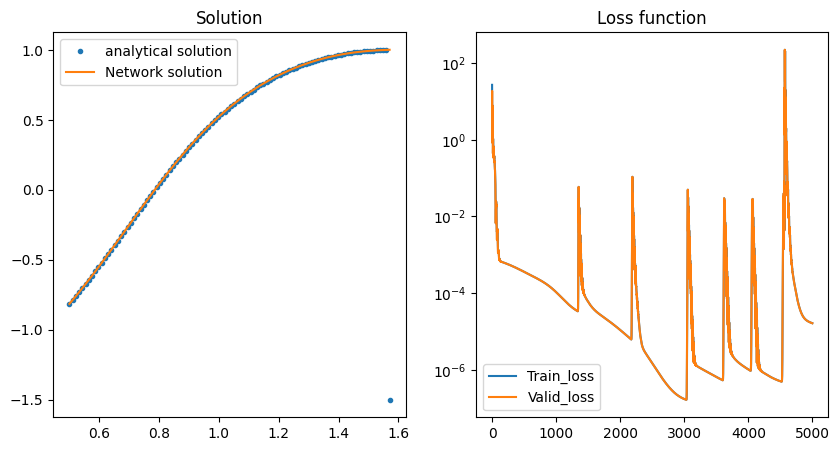

iteration = 50
number of epoch = 5000 
net_0_opt.param_groups[0][lr] = 0.01 


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from neurodiffeq.neurodiffeq import safe_diff as diff
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.conditions import IVP
from neurodiffeq.conditions import DirichletBVP
from neurodiffeq.networks import Swish
from IPython.display import display, clear_output
alpha = -0.1
Lambda = 0.
T_min = 0.5
T_max = np.pi/2

#epochs = 8000

from neurodiffeq.networks import FCNN
import torch.nn as nn

net_0 = FCNN(hidden_units = (128,128,128), actv=Swish)

#monitor = Monitor1D(t_min = T_min, t_max = T_max, check_every=epochs)

#monitor_callback = monitor.to_callback()

differential_equation = lambda g,x :[((12 * alpha * g - 12 * alpha - 3) * torch.cos(x) ** 3 + 3 * torch.cos(x)) * diff(g, x) + 6 * torch.sin(x) * (g - 1)]

init_val = IVP(t_0=np.arctan(1), u_0 = 0)

from torch.optim import SGD
from itertools import chain 

nets = [net_0]

sgd = SGD(chain.from_iterable(n.parameters() for n in nets), lr=0.01, momentum=0.99)

from torch.optim import Adam

adam = Adam(chain.from_iterable(n.parameters() for n in nets), lr=0.01,)

from neurodiffeq.generators import Generator1D

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

#g1 =  Generator1D(size=500, t_min=T_min, t_max = T_max, method = 'uniform')
#g2 =  Generator1D(size=200, t_min=T_max/2., t_max = T_max, method = 'uniform')
train_gen = Generator1D(size=128, t_min=T_min, t_max = T_max, method = 'equally-spaced')
valid_gen = Generator1D(size=128, t_min=T_min, t_max = T_max, method = 'equally-spaced')

solver = Solver1D(ode_system  = differential_equation,
                 conditions = [init_val],
                 t_min = T_min,
                 t_max = T_max,
                 nets = [net_0],
                 train_generator = train_gen,
                 valid_generator = valid_gen,
                 optimizer = adam)
net_0_opt = solver.optimizer
net_0 = solver.nets
net_0_opt.param_groups[0]['lr'] = 0.01
train_loss = []
valid_loss = []
for i in range(50):
    solver = Solver1D(ode_system  = differential_equation,conditions = [init_val],t_min = T_min,t_max = T_max,nets = net_0, train_generator = train_gen,valid_generator = valid_gen, optimizer = net_0_opt)
    numepoch = 100
    solver.fit(max_epochs=numepoch)
    #extract the net data
    net_0 = solver.nets
    net_0_opt = solver.optimizer
    solution_net = solver.get_solution()
    net_0_opt.param_groups[0]['lr'] = 0.01 #- 0.00001*(i)
    ax[0].clear()
    ax[1].clear()
    alpha = -0.1
    M = -alpha + 0.5
    f_analytic = lambda x,alpha: (4 * alpha + 1) / alpha / 4 + (-1 + np.sqrt(-16 * np.cos(x) ** 4 * alpha * M + np.cos(x) ** 4 - 2 * np.cos(x) ** 2 + 1)) / alpha / np.cos(x) ** 2 / 4
    ts = np.linspace(T_min, T_max, 100)
    u_net = solution_net(ts, to_numpy=True)
    u_ana = f_analytic(ts,alpha)
    train_loss+=solver.metrics_history["train_loss"]
    valid_loss+=solver.metrics_history["valid_loss"]
    ax[0].set_title("Solution")
    ax[0].plot(ts, u_ana,".", label='analytical solution')
    ax[0].plot(ts, u_net,label='Network solution')
    ax[0].legend()
    #ax[0].set_aspect('equal')
    ax[1].plot(train_loss,label="Train_loss")
    ax[1].plot(valid_loss,label="Valid_loss")
    ax[1].set_title("Loss function")
    ax[1].set_yscale('log')
    ax[1].legend()
    #ax[1].set_aspect('auto')
    clear_output(wait=True)
    display(fig)
    print(f'iteration = {i+1}\nnumber of epoch = {(i+1)*numepoch} ')
    print("net_0_opt.param_groups[0][lr] = " +str(net_0_opt.param_groups[0]['lr'])+ " ")

plt.close()
#solver.fit(max_epochs = epochs, callbacks = [monitor_callback])
#solution = solver.get_solution()


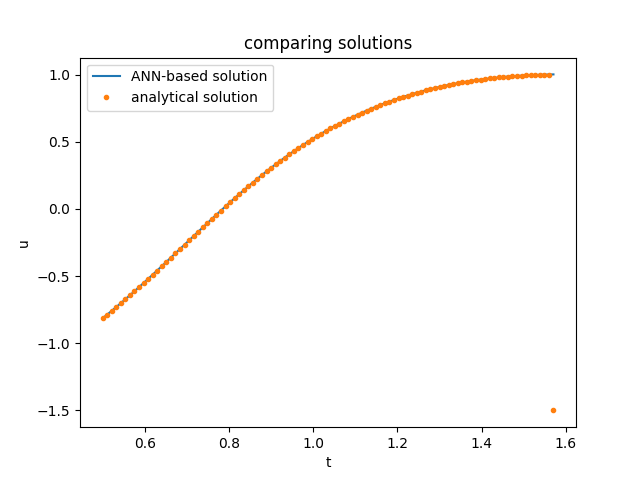

In [7]:
ts = np.linspace(T_min, T_max, 100)
u_net = solution_net(ts, to_numpy=True)
M = 0.5-alpha
#M=1.
u_ana = lambda x,alpha :(4 * alpha + 1) / alpha / 4 + (-1 + np.sqrt(-16 * np.cos(x) ** 4 * alpha * M + np.cos(x) ** 4 - 2 * np.cos(x) ** 2 + 1)) / alpha / np.cos(x) ** 2 / 4

plt.figure()
plt.plot(ts, u_net, label='ANN-based solution')
plt.plot(ts, u_ana(ts,alpha), '.', label='analytical solution')
plt.ylabel('u')
plt.xlabel('t')
#plt.xlim(0,1.6)
#plt.ylim(-1.4,0.2)
plt.title('comparing solutions')
plt.legend()
plt.show()

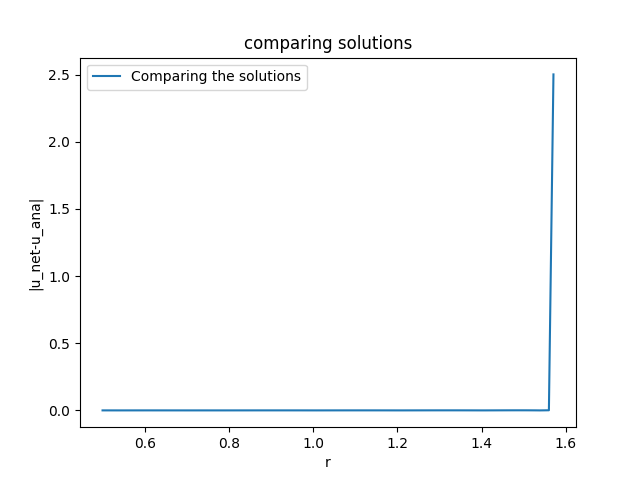

0.02521316996667244


In [10]:
plt.figure()
plt.plot(ts,np.abs(u_net-u_ana(ts,alpha)), label='Comparing the solutions')
plt.ylabel('|u_net-u_ana|')
plt.xlabel('r')
plt.title('comparing solutions')
plt.legend()
plt.show()
print(np.mean(np.abs(u_net-u_ana(ts,alpha))))

**In this case the solution have a precision $\sim 10^{-2}$**

# Bundle Solution of EGB5D #

The bundle solution allows $\alpha$ to be a dynamic parameter and solves the equation for all $\alpha$. The initial conditions of the differential equation are set to solve it. However, unlike the usual IVP in NeurodiffEq, the Bundle IVP is used. This method works as follows, given the type of initial condition 

- Dirichlet: $f(r_0,\alpha) = f_0$
- Neumann: $\frac{d f }{dr} (r,\alpha)|_{r_0} = f_0'$

donde $\alpha= \{\alpha_1, \alpha_2, \alpha_3,...,\alpha_n\} \in \mathbb{R}^n $. Here we set $\alpha \in [-1,0]$ and $x \in [0,\pi/2)$.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
#%matplotlib ipympl
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.solvers import BundleSolver1D
from neurodiffeq.generators import Generator2D
from neurodiffeq.conditions import BundleIVP  # the initial condition
from neurodiffeq.conditions import IVP
from neurodiffeq.monitors import Monitor1D 
from torch.optim import Adam#Adam optimizer
from neurodiffeq.networks import FCNN    # fully-connect neural network
import torch
import torch.nn as nn
from itertools import chain
from IPython.display import display, clear_output

In [16]:
t_min = 0.5
t_max = np.pi/2
alpha_min = -1
alpha_max = 0
EGB5D =  lambda g, x, alpha:[  ((12 * alpha * g - 12 * alpha - 3) * torch.cos(x) ** 3 + 3 * torch.cos(x)) * diff(g, x) + 6 * torch.sin(x) * (g - 1)]


In [17]:
init_val_h = [BundleIVP(t_0=np.arctan(1),
                        u_0= 0.0)]#      # specify the initial conditon

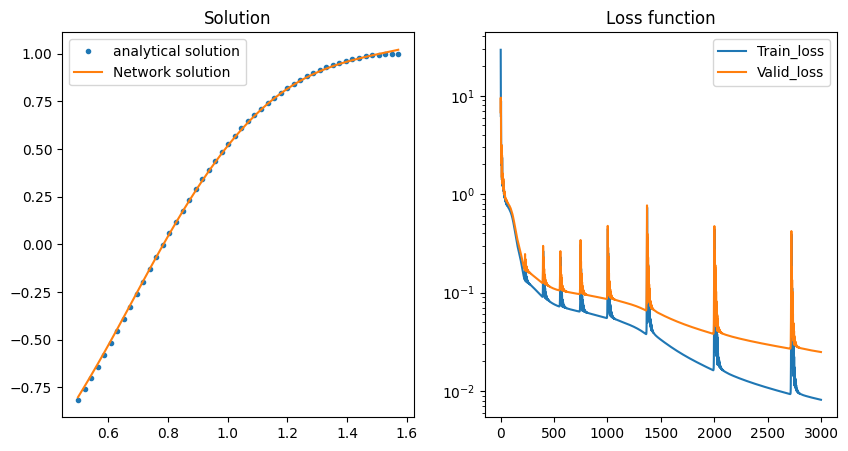

iteration = 30
number of epoch = 3000 
net_0_opt.param_groups[0][lr] = 0.01 


In [18]:
#printing things
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

setmeanval = []
signtrack = []

## Neural network
g1 = Generator2D(grid=(150,100),xy_min=(t_min,alpha_min),xy_max=(t_max,alpha_max),method='equally-spaced')
#g2 = Generator2D(grid=(100,50),xy_min=(0.5,-1),xy_max=(20,-10),method='equally-spaced')
train_gen = g1 #+ g2
valid_gen = Generator2D(grid=(50,25),xy_min=(t_min,alpha_min),xy_max=(t_max,alpha_max),method='equally-spaced')
net_0 = FCNN(n_input_units=2,n_output_units=1, hidden_units=(128, 64), actv=nn.SiLU) #Tanh works fine but SiLU?
Adam_0 = Adam( chain.from_iterable(n.parameters() for n in [net_0]), # this gives all parameters in `nets`
        lr=0.01, )
my_solver = BundleSolver1D(
    ode_system=EGB5D,
    conditions=init_val_h,
    t_min=t_min,
    t_max=t_max,
    theta_min=alpha_min,  # Mínimo de theta
    theta_max=alpha_max,   # Máximo de theta
    eq_param_index=(0,),
    n_batches_valid=1,# λ is the only equation parameter, which has index 0
    train_generator = train_gen,
    valid_generator = valid_gen,
    nets=[net_0],
    optimizer=Adam_0
)
net_0_opt = my_solver.optimizer
net_0 = my_solver.nets
net_0_opt.param_groups[0]['lr'] = 0.01
train_loss = []
valid_loss = []
for i in range(30):
    my_solver = BundleSolver1D(
    ode_system=EGB5D,
    conditions=init_val_h,
    t_min=t_min,
    t_max=t_max,
    theta_min=alpha_min,  # Mínimo de theta
    theta_max=alpha_max,   # Máximo de theta
    eq_param_index=(0,),
    n_batches_valid=1,# λ is the only equation parameter, which has index 0
    train_generator = train_gen,
    valid_generator = valid_gen,
    nets=net_0,
    optimizer=net_0_opt)
    #here set epochs
    numepoch = 100
    my_solver.fit(max_epochs=numepoch)
    #extract the net data
    net_0 = my_solver.nets
    net_0_opt = my_solver.optimizer
    solution_net4 = my_solver.get_solution()
    if i%5 == 0:
        net_0_opt.param_groups[0]['lr'] = 0.01 #- 0.00001*(i)
    ax[0].clear()
    ax[1].clear()
    ts = np.linspace(t_min, t_max-0.0001, 50)
    alpha = -0.1 * np.ones_like(ts)
    M = -alpha + 0.5
    f_analytic = lambda x,alpha:(4 * alpha + 1) / alpha / 4 + (-1 + np.sqrt(-16 * np.cos(x) ** 4 * alpha * M + np.cos(x) ** 4 - 2 * np.cos(x) ** 2 + 1)) / alpha / np.cos(x) ** 2 / 4
    u_net = solution_net4(ts, alpha, to_numpy=True)
    u_ana = f_analytic(ts,alpha)
    train_loss+=my_solver.metrics_history["train_loss"]
    valid_loss+=my_solver.metrics_history["valid_loss"]
    ax[0].set_title("Solution")
    ax[0].plot(ts, u_ana,".", label='analytical solution')
    ax[0].plot(ts, u_net,label='Network solution')
    ax[0].legend()
    #ax[0].set_aspect('equal')
    ax[1].plot(train_loss,label="Train_loss")
    ax[1].plot(valid_loss,label="Valid_loss")
    ax[1].set_title("Loss function")
    ax[1].set_yscale('log')
    ax[1].legend()
    #ax[1].set_aspect('auto')
    clear_output(wait=True)
    display(fig)
    print(f'iteration = {i+1}\nnumber of epoch = {(i+1)*numepoch} ')
    print("net_0_opt.param_groups[0][lr] = " +str(net_0_opt.param_groups[0]['lr'])+ " ")
plt.close()

In the following cell, I programmed an interactive version of the solution. For a function $ f(r) $ with $ r $ ranging from $0$ to $\infty$ (using the inverse variable transformation), you can see how $ f(r) $ changes as $ \alpha $ varies from $-1$ to $0$.

interactive(children=(FloatSlider(value=-0.51, description='alpha1', max=-0.01, min=-1.0, step=0.01), Output()…

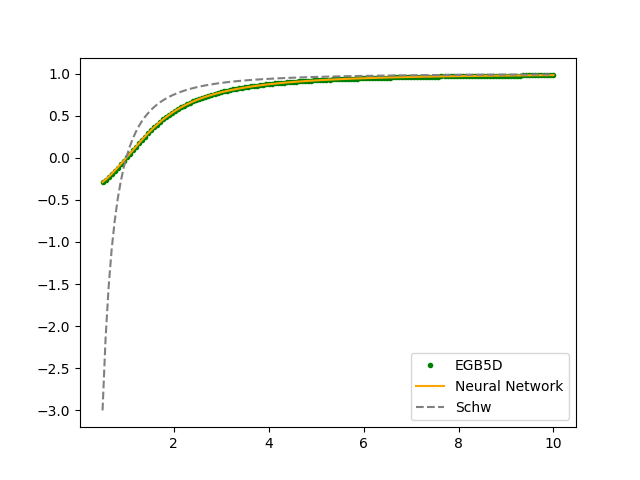

In [19]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

r = np.linspace(0.5, 10, 150)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

alpha1 = -1.0
f_analytic4 = lambda x,alpha:(4 * alpha + 1) / alpha / 4 + (-1 + np.sqrt(-16 * np.cos(x) ** 4 * alpha *(-alpha+0.5) + np.cos(x) ** 4 - 2 * np.cos(x) ** 2 + 1)) / alpha / np.cos(x) ** 2 / 4
f_schw = lambda x : 1 - 1/x**2

line, = ax.plot(r, f_analytic4(np.arctan(r),alpha1),".",c="green",label="EGB5D")
line1, = ax.plot(r,solution_net4(np.arctan(r), alpha1*np.ones_like(r), to_numpy=True),c="orange",label="Neural Network")
line2, = ax.plot(r,f_schw(r),"--",c="gray",label="Schw")
ax.legend(loc="best")
def update4(alpha1):
    line.set_ydata(f_analytic4(np.arctan(r),alpha1))
    line1.set_ydata(solution_net4(np.arctan(r), alpha1*np.ones_like(r), to_numpy=True))
    line2.set_ydata(f_schw(r))
    fig.canvas.draw_idle()

interact(update4,alpha1=(-1,-0.01,0.01));